### Libraries

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

### Get Data
<ol>
    <li> We get the, previously cleansed, <i>train</i> dataset.
    <li> We scale the numerical features <code>Age</code> and <code>Fare</code>.
</ol>

In [23]:
X = pd.read_hdf('../wip-data/X_train.h5', key = 'df')
y = pd.read_hdf('../wip-data/y_train.h5', key = 'df')

X[['Age', 'Fare']] = StandardScaler().fit_transform(X[['Age', 'Fare']])

### Learning Curves
<ol>
    <li> We plot learning curves for the <i>train</i> dataset using a support vector classifier with three different kernels - <code>linear, rbf</code> and <code>polynomial</code>. This allows us to gain better insight into the bias-variance tradeoff we are likely to encounter in fitting a SVC model and better inform our choice of a appropriate model for the given dataset.
</ol>

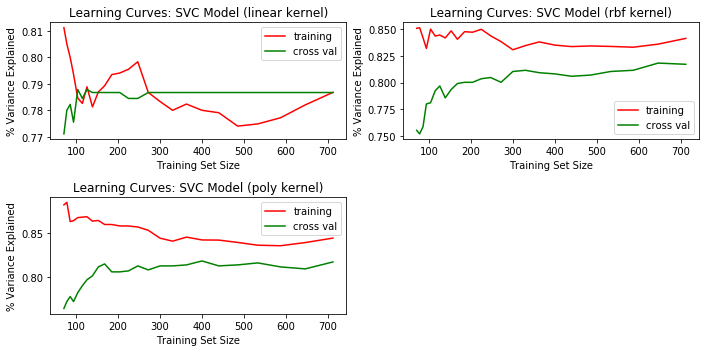

In [52]:
kernels = ['linear', 'rbf', 'poly']
plt.figure(figsize = (10,5))

for i in range(len(kernels)):
    svc = SVC(kernel = kernels[i], max_iter = -1, random_state = 1970)
    train_sizes, train_scores, val_scores = learning_curve(svc, X, y, train_sizes = np.logspace(-1, 0, 25), 
                                                           shuffle = True, random_state = 1970)
    plt.subplot(2,2,i+1)
    plt.plot(train_sizes, train_scores.mean(axis = 1), label = 'training', color = 'red')
    plt.plot(train_sizes, val_scores.mean(axis = 1), label = 'cross val', color = 'green')
    plt.xlabel('Training Set Size')
    plt.ylabel('% Variance Explained')
    plt.legend()
    plt.title('Learning Curves: SVC Model (%s kernel)' % kernels[i])

plt.tight_layout()
plt.show()

#### Observation
<ol>
    <li> The learning curves for the three kernels behave differently: For the <code>linear</code> kernel, the two curves rapidly converge indicating that a SVC Model with a <code>linear</code> kernel is likely to "suffer" from a <i>bias</i> rather than a <i>variance</i> problem.
    <li> On the other hand for the other two kernels - <code>rbf</code> and <code>polynomial</code>, the two curves come closer without really converging indicating that a SVC Model with either of these kernels is likely to "suffer" from a <i>variance</i> rather than a <i>bias</i> problem
    <li> For the <code>linear</code> kernel, the model performance can be improved by either getting more data points (not possible in this case) or increasing the number of features (by developing, say, interaction features) included in the model.
    <li> For the other two kernels, the model performace can be improved by reducing (regularizing) the number of features included in the model.
</ol>

### SVC Models
<ol>    
    <li> We use the <i>train-validate</i> strategy to estimate the test set accuracy.
    <li> We build models using different kernels - <code>linear, rbf</code> and <code>polynomial</code>
    <ol>
        <li> For each of these models there are parameters that affect the performance of the model and we need to choose their optimal values.
    </ol>
    <li> For the model with <code>linear</code> kernel, we introduce new features by including polynomial and interaction terms using the original features.
</ol>

In [53]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 1970)
poly_feat = PolynomialFeatures()
svc = SVC(max_iter = -1, random_state = 1970)
clf = GridSearchCV(estimator = svc, param_grid = grid, scoring = 'accuracy')

In [56]:
grid = {'kernel':['linear'], 'C':[1, 10, 100]} 

pipeline = make_pipeline(poly_feat, clf)
pipeline.fit(X_train, y_train)
est_test_acc = pipeline.score(X_val, y_val)*100
print("The estimated test set accuracy for a linear kernel SVC with polynomial and interaction features = %f" 
      % est_test_acc,"%")

The estimated test set accuracy for a linear kernel SVC with polynomial and interaction features = 81.564246 %


In [67]:
X_train.shape

(712, 14)

In [64]:
grid = {'kernel' : ['rbf'], 'C' : [1, 10, 100], 'gamma' : ['scale', 'auto']} 

est_test_acc = cross_val_score(clf, X, y).mean()*100

print(est_test_acc)

78.67365513778168


In [70]:
grid = {'kernel' : ['rbf'], 'C' : [0.1, 1, 10, 100], 'gamma' : [0.007, 0.07, 0.7]} 
clf.fit(X_train, y_train)
clf.score(X_val, y_val)

0.7374301675977654

In [66]:
grid = {'kernel' : ['rbf'], 'C' : [1, 10, 100], 'gamma' : ['scale', 'auto']} 
pipeline = make_pipeline(poly_feat, clf)
pipeline.fit(X_train, y_train)
est_test_acc = pipeline.score(X_val, y_val)*100
print("The estimated test set accuracy for a linear kernel SVC with polynomial and interaction features = %f" 
      % est_test_acc,"%")

The estimated test set accuracy for a linear kernel SVC with polynomial and interaction features = 81.564246 %


#### Observations
<ol>
    <li>The estimated test set accuracy for the model with reduced set of features remains exactly the same as the baseline and this indicates we can eliminate the identified feature without any adverse impact.
    <li> Recall that the learning curves indicate that the quality of a regression model would improve with either additional data or additional features.
    <li> We introduce new features by adding polynomial and interaction features, built from the original features in the dataset, and use this enhanced feature set to build a new logistic regression model.
    <li> Adding new features is likely to dramatically increase the number of features and we will use both L1 penalty and L2 penalty to regularize the regression models.
    <li> We will ascertain if the models with additional (regularized) features improve on the baseline estimated test error.
 </ol>

In [35]:
X_train = X_train.drop('Fare', axis = 1)
X_val = X_val.drop('Fare', axis = 1)

In [36]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

poly_feat = PolynomialFeatures()
clf_logit_ridge = LogisticRegression(max_iter = 10000, penalty = 'l2', random_state = 1970)
clf_logit_lasso = LogisticRegression(max_iter = 10000, penalty = 'l1', random_state = 1970, solver = 'liblinear')

pipe_ridge = make_pipeline(poly_feat, clf_logit_ridge)
pipe_ridge.fit(X_train, y_train)
est_test_acc = pipe_ridge.score(X_val, y_val)*100
print("The estimated test set accuracy for a logistic model with polynomial and interaction features but Ridge regularized = %f" % est_test_acc,"%")

pipe_lasso = make_pipeline(poly_feat, clf_logit_lasso)
pipe_lasso.fit(X_train, y_train)
est_test_acc = pipe_lasso.score(X_val, y_val)*100
print("The estimated test set accuracy for a logistic model with polynomial and interaction features but Lasso regularized = %f" % est_test_acc,"%")

The estimated test set accuracy for a logistic model with polynomial and interaction features but Ridge regularized = 81.564246 %
The estimated test set accuracy for a logistic model with polynomial and interaction features but Lasso regularized = 81.005587 %


#### Observations
<ol>
    <li> The estimated test set accuracy for both model with polynomial and interaction features is substandially better than the baseline number, with the Ridge penalized model doing slightly better than the Lasso penalized model.
    <li> The Ridge penalized model with polynomial and interactin features represents the best model when using the Logistic Regression algorithm
 </ol>